In [1]:
import pandas as pd
import os
import re
import networkx as nx
import networkx.algorithms.community as nx_comm
from networkx.algorithms.community.label_propagation import label_propagation_communities
# from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import numpy as np
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
import difflib


import geopandas as gpd

from libs.mrqap import MRQAP # source: https://github.com/lisette-espin/mrqap-python
import geopy.distance
import itertools


In [2]:
_DATA_DIRECTORY = 'C:\\Users\\josia\\Documents\\GitHub\\modernDataAnalytics2022\\data\\'
path = "C:\\Users\\josia\\Documents\\GitHub\\modernDataAnalytics2022"

def full_path(path):
    return os.path.join(_DATA_DIRECTORY, path)

In [3]:
# relative paths weren't working for me for some damn reason
from os import listdir
from os.path import isfile, join
os.listdir("data")
os.getcwd()
# onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]

'C:\\Users\\josia\\Documents\\GitHub\\modernDataAnalytics2022'

In [4]:
# Data imports here my duder
path = "C:\\Users\\josia\\Documents\\GitHub\\modernDataAnalytics2022"
data_1 = pd.read_excel("C:\\Users\\josia\\Documents\\GitHub\\modernDataAnalytics2022\\data\\ESC-2014-first_semi-final-full_results.xls")

In [5]:
def Eurovision_Decade_DataFrame(csv_path, vote_type = "Both", round_type = "all", y1="NA", y2="NA"):
    # probably enforce types or something here
    
    
    longform_data = pd.read_csv(csv_path)
    longform_data = longform_data[longform_data["From country"] != longform_data_decades["To country"]]
    longform_data = longform_data.replace('F.Y.R. Macedonia','Macedonia')
    contest_round = list(longform_data['(semi-) final'].unique())
    for version in contest_round:
        locals()["census_"+str(version)] = longform_data[longform_data['(semi-) final']==version].groupby('Year').nunique()[['From country','To country']]
        locals()["census_"+str(version)]['(semi-) final'] = str(version)
        locals()["census_"+str(version)].reset_index()
        locals()["census_"+str(version)].rename(columns = {'From country':'sum_senders_'+str(version), 'To country':'sum_receivers_'+str(version)}, inplace = True)
        if contest_round.index(version) == 0: 
            merged_rounds = pd.merge(longform_data, locals()["census_"+str(version)], how='left', on=['Year', '(semi-) final'])
        else:
            merged_rounds = pd.merge(merged_rounds, locals()["census_"+str(version)], how='left', on=['Year', '(semi-) final'])
    merged_rounds = merged_rounds.fillna(0)

    merged_rounds["sum_senders"] = merged_rounds["sum_senders_sf"] + merged_rounds["sum_senders_sf1"] + merged_rounds["sum_senders_f"] + merged_rounds["sum_senders_sf2"] 
    merged_rounds["sum_receivers"] = merged_rounds["sum_receivers_sf"] + merged_rounds["sum_receivers_sf2"] + merged_rounds["sum_receivers_f"]  + merged_rounds["sum_receivers_sf1"] 
    merged_rounds = merged_rounds.drop(['sum_senders_sf', 'sum_senders_sf1', "sum_senders_f", 'sum_senders_sf2', 'sum_receivers_sf', "sum_receivers_sf2", "sum_receivers_f", "sum_receivers_sf1"], axis=1)
    merged_rounds['Decade'] = (10 * (merged_rounds['Year'] // 10)).astype(str) + 's'
    merged_rounds["average_points"] = merged_rounds["Points"]/merged_rounds["sum_senders"]
    
    if round_type != "all" and round_type == "finals":
        merged_rounds = merged_rounds[merged_rounds['(semi-) final'] == "f"]
    elif round_type != "all" and round_type == "semis":
        merged_rounds = merged_rounds[(merged_rounds['(semi-) final'] == "sf") | (merged_rounds['(semi-) final'] == "sf1") | (merged_rounds['(semi-) final'] == "sf2")]
    else:
        pass
    merged_rounds["contests_incl"] = str(round_type)
    
    if y1 != "NA" and y2 != "NA":
        merged_rounds = merged_rounds[(merged_rounds['Year'] >= y1) & (merged_rounds['Year'] <= y2)]
    else:
        pass
    
    if vote_type == "J" or vote_type == "T":
        merged_rounds = merged_rounds[merged_rounds["Jury or Televoting"] == vote_type]
        decade_grouping = merged_rounds.groupby(["Decade","From country", "To country"]).sum()
        decade_grouping = decade_grouping.reset_index()
    else:
        decade_grouping = merged_rounds.groupby(["Decade","From country", "To country"]).sum()
        decade_grouping = decade_grouping.reset_index()
    decade_grouping["Contests_Shared"] = (decade_grouping["Year"]/2000).round(0).astype(int)
    return decade_grouping


In [6]:

def similar(landstring, country):
    shitter = process.extractOne(landstring, country, score_cutoff=90)
    if shitter == None:
        return "NA"
    else:
        return shitter[0]
    

In [7]:
def fuzzy_merge(df_1, df_2, key1, key2, threshold=90, limit=1):
    s = df_2[key2].tolist()
    m = df_1[key1].apply(lambda x: process.extract(x, s, limit=limit))    
    df_1['matches'] = m
    m2 = df_1['matches'].apply(lambda x: ', '.join([i[0] for i in x if i[1] >= threshold]))
    df_1['matches'] = m2
    
    return df_1

In [8]:
def Decade_subset(df_decades, decade="all"):
    if decade == "all":
        return df_decades     
    else:
        locals()["eurovision_"+str(decade)] = df_decades[df_decades["Decade"] == str(decade)+"s"].sort_values(by=['average_points'],  ascending=False)
        return locals()["eurovision_"+str(decade)]

In [9]:
# maybe it would be best to split this function up somehow...
%matplotlib inline
def network_and_communities(dataframe, show_plot = "N"):
    dataframe_network = nx.from_pandas_edgelist(dataframe, "From country", "To country", ["average_points"])
    communities = label_propagation_communities(dataframe_network)
    print([community for community in communities])

    
    nx.draw(dataframe_network)
    if show_plot == "Y":
        plt.show()
    else:
        pass
    return dataframe_network


In [10]:
# some function to subset the duders by their favorites

# the nlargest memer isn't working properly, needs to be the top of each country methinks...

# need to redo the flow of this, if years is something then it doesn't return what I want 
def cutoff_values(dataframe, min_years_with = "all", top="NA", points="NA"):
    if min_years_with != "all" and top != "NA":
        dataframe = dataframe[dataframe["Contests_Shared"] >= min_years_with]
    else:
        if top != "NA":
            favorites = dataframe.nlargest(top, 'average_points')
        else:
            pass
        if points != "NA":
            favorites = dataframe[dataframe["average_points"] >= points]
        else:
            pass
    return favorites

In [11]:
# some function to give some basic characteristics of whatever network is passed to it..
def network_characteristics(dataframe, weight = "average_points"):
    network_of_interest = nx.from_pandas_edgelist(dataframe, "From country", "To country", [weight],
                                   create_using=nx.DiGraph())
    census = nx.triadic_census(network_of_interest)
    centrality = nx.degree_centrality(network_of_interest)
    centrality = pd.DataFrame.from_dict(centrality, orient='index', columns=['centrality']).sort_values(by=["centrality"], ascending=False)
    return census, centrality
    

In [12]:
longform_data_decades = pd.read_csv("C:\\Users\\josia\\Documents\\GitHub\\modernDataAnalytics2022\\data\\Voting_totals.csv")
shitteringo = list(longform_data_decades['(semi-) final'].unique())
shitteringo.index('f')


testererer = Eurovision_Decade_DataFrame("C:\\Users\\josia\\Documents\\GitHub\\modernDataAnalytics2022\\data\\Voting_totals.csv", 
                                         round_type = "semis")

testererer
# testererer[testererer["From country"] == "Australia"].sort_values(by=['average_points'],  ascending=False)
# cutoff_values(testererer,  min_years_with = 5, points = 3)

# testererer.sort_values(by=['Contests_Shared'],  ascending=True).head(20)
# testererer[(testererer["Contests_Shared"] == 1) & (testererer["Decade"] == "2010s")]


# testererer[(testererer["From country"] == "Albania") & (testererer["To country"] == "Macedonia")]
# s4[(s4['Year'] >= 2000) & (s4['Year'] <= 2005)]
# print(network_characteristics(cutoff_values(testererer, points = 3)))
# network_characteristics(cutoff_values(testererer, points = 3), weight = "Points")


# network_and_communities(Decade_subset(testererer, decade = "1980"))
# Decade_subset(testererer, decade = "1980")

,Decade,From country,To country,Year,Points,Duplicate,sum_senders,sum_receivers,average_points,Contests_Shared
0,2000s,Albania,Andorra,8022,6,0.0,155.0,98.0,0.153846,4
1,2000s,Albania,Armenia,2006,3,0.0,38.0,23.0,0.078947,1
2,2000s,Albania,Austria,4012,5,0.0,81.0,53.0,0.128205,2
3,2000s,Albania,Azerbaijan,2009,0,0.0,22.0,19.0,0.000000,1
4,2000s,Albania,Belarus,10030,4,0.0,177.0,117.0,0.095238,5
...,...,...,...,...,...,...,...,...,...,...
3584,2010s,United Kingdom,Sweden,10071,21,0.0,103.0,88.0,1.015038,5
3585,2010s,United Kingdom,Switzerland,16118,9,0.0,165.0,142.0,0.443723,8
3586,2010s,United Kingdom,The Netherlands,6035,12,0.0,59.0,51.0,0.611529,3
3587,2010s,United Kingdom,Turkey,6033,15,0.0,61.0,54.0,0.754386,3


In [37]:

def proc_english(dataframe):
    english = pd.read_csv(full_path(dataframe),  header=0,  skiprows=1)
    english = english.rename(columns = {'%':'percent_english'})
    english["percent_english"] = english["percent_english"].str.replace("2012", "")
    english["percent_english"] =  [re.sub(r"\((.*?)\)", "", str(x)) for x in english["percent_english"]]

    participants = Eurovision_Decade_DataFrame("C:\\Users\\josia\\Documents\\GitHub\\modernDataAnalytics2022\\data\\Voting_totals.csv", 
                                         round_type = "all")["From country"].unique()
    match_dict = dict((land, similar(land.upper(), english["Country"])) for land in participants)
    match_dict = pd.DataFrame.from_dict(match_dict, orient='index')
    match_dict.reset_index()
    match_dict['Country'] = match_dict.index

    eng_data = fuzzy_merge(english, match_dict, 'Country', 'Country', threshold=90, limit=1)
    eng_data['matches'].replace('', np.nan, inplace=True)
    eng_data.dropna(subset=['matches'], inplace=True)
    eng_data = eng_data.drop(['Country'], axis=1)
    eng_data["percent_english"] = eng_data["percent_english"].astype(float)
    eng_data = eng_data.drop(['No.', 'Eligible population', 'No..1', '%.1', 'No..2', '%.2', 'Notes'], axis=1)
    return eng_data



In [14]:
# gonna take a global variable... the output of Eurovision

def proc_gdppc(dataframe, year = "all"):
    gdp_per_capita = pd.read_csv(full_path(dataframe),  header=0)
    if year != "all":
        gdp_per_capita = gdp_per_capita[gdp_per_capita["Year"] == int(year)]
    else:
        pass
    participants = Eurovision_Decade_DataFrame("C:\\Users\\josia\\Documents\\GitHub\\modernDataAnalytics2022\\data\\Voting_totals.csv", 
                                         round_type = "all")["From country"].unique()
    match_dict = dict((land, similar(land.upper(), gdp_per_capita["Entity"])) for land in participants)
    match_dict = pd.DataFrame.from_dict(match_dict, orient='index')
    match_dict.reset_index()
    match_dict['Country'] = match_dict.index

    merged_data = fuzzy_merge(gdp_per_capita, match_dict, 'Entity', 'Country', threshold=90, limit=1)
    merged_data['matches'].replace('', np.nan, inplace=True)
    merged_data.dropna(subset=['matches'], inplace=True)
    merged_data = merged_data.drop(['Code', 'Entity'], axis=1)
    merged_data.rename(columns={r"GDP per capita, PPP (constant 2017 international $)": "GDP_PPP_2017_dol"}, errors="raise", inplace=True)
    merged_data["GDP_PPP_2017_dol"] = merged_data["GDP_PPP_2017_dol"].round(2)
    return merged_data

[{'Denmark', 'Belgium', 'Portugal', 'Germany'}, {'Norway', 'United Kingdom', 'Switzerland', 'Ireland', 'Sweden', 'Luxembourg', 'Austria'}, {'Yugoslavia', 'Turkey', 'Spain', 'Italy'}]


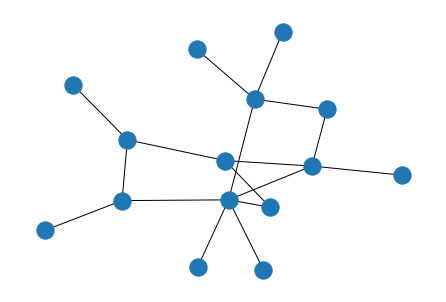

In [15]:
testererer = Decade_subset(Eurovision_Decade_DataFrame("C:\\Users\\josia\\Documents\\GitHub\\modernDataAnalytics2022\\data\\Voting_totals.csv", 
                                         round_type = "all"), decade = "1980")

network_and_communities(cutoff_values(testererer,  min_years_with = 5, points = 3), show_plot = "Y")

[{'Greece', 'Cyprus'}, {'Norway', 'France'}, {'Sweden', 'Iceland'}, {'United Kingdom', 'Belgium', 'Ireland'}]


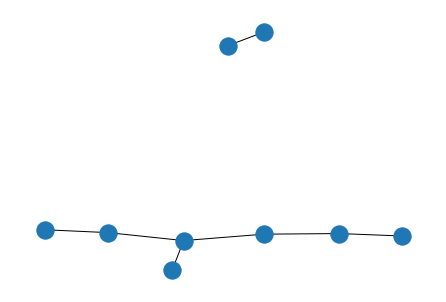

In [16]:
testererer = Decade_subset(Eurovision_Decade_DataFrame("C:\\Users\\josia\\Documents\\GitHub\\modernDataAnalytics2022\\data\\Voting_totals.csv", 
                                         round_type = "all"), decade = "1990")

network_and_communities(cutoff_values(testererer, top = 8), show_plot = "Y")

[{'Germany', 'Turkey', 'France', 'The Netherlands'}, {'Bosnia & Herzegovina', 'Slovenia', 'Croatia'}, {'Estonia', 'Russia', 'Latvia'}, {'Denmark', 'Sweden', 'Iceland'}, {'Greece', 'Cyprus'}, {'United Kingdom', 'Ireland'}]


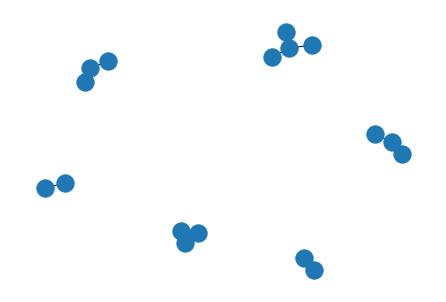

In [17]:
testererer = Decade_subset(Eurovision_Decade_DataFrame("C:\\Users\\josia\\Documents\\GitHub\\modernDataAnalytics2022\\data\\Voting_totals.csv", 
                                         round_type = "all", y1 = 2000, y2 = 2006), decade = "2000")

network_and_communities(cutoff_values(testererer, top = 15), show_plot = "Y")

[{'United Kingdom', 'Macedonia', 'France', 'Albania', 'Germany', 'Turkey', 'Belgium'}, {'Armenia', 'Russia', 'Israel'}, {'Switzerland', 'Portugal'}, {'Slovenia', 'Bosnia & Herzegovina'}, {'Sweden', 'Finland', 'Iceland'}]


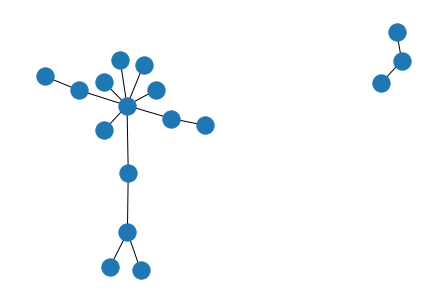

In [18]:
testererer = Decade_subset(Eurovision_Decade_DataFrame("C:\\Users\\josia\\Documents\\GitHub\\modernDataAnalytics2022\\data\\Voting_totals.csv", 
                                         round_type = "all", y1 = 2006, y2 = 2010), decade = "2000")

network_and_communities(cutoff_values(testererer, top = 15), show_plot = "Y")

[{'The Netherlands', 'France', 'Germany', 'Turkey', 'Belgium'}, {'Estonia', 'Latvia', 'Russia', 'Lithuania'}, {'Greece', 'Cyprus'}, {'Denmark', 'Sweden', 'Iceland'}, {'Bosnia & Herzegovina', 'Slovenia', 'Croatia'}]


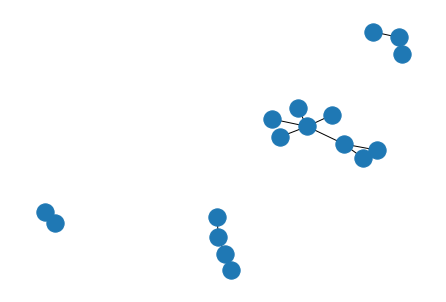

In [19]:
testererer = Decade_subset(Eurovision_Decade_DataFrame("C:\\Users\\josia\\Documents\\GitHub\\modernDataAnalytics2022\\data\\Voting_totals.csv", 
                                         round_type = "all"), decade = "2000")

network_and_communities(cutoff_values(testererer, top = 15), show_plot = "Y")

[{'Albania', 'Greece', 'Cyprus'}, {'Moldova', 'Romania', 'Russia'}, {'Denmark', 'Sweden', 'Norway'}, {'United Kingdom', 'Ireland', 'Lithuania'}, {'Serbia', 'Macedonia'}, {'Georgia', 'Azerbaijan'}, {'Ukraine', 'Belarus'}]


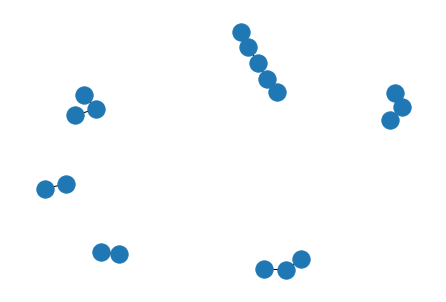

In [20]:
testererer = Decade_subset(Eurovision_Decade_DataFrame("C:\\Users\\josia\\Documents\\GitHub\\modernDataAnalytics2022\\data\\Voting_totals.csv", 
                                         round_type = "all"), decade = "2010")

network_and_communities(cutoff_values(testererer, top = 15), show_plot = "Y")

[{'Greece', 'Cyprus', 'Armenia'}, {'United Kingdom', 'Lithuania', 'Ireland'}, {'Serbia', 'Hungary', 'Switzerland', 'Slovenia'}, {'Bulgaria', 'Macedonia', 'Israel'}, {'Azerbaijan', 'Czech Republic'}, {'Denmark', 'Norway'}, {'Ukraine', 'Poland', 'Italy'}]


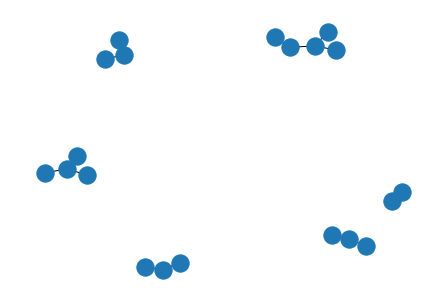

In [21]:
testererer = Eurovision_Decade_DataFrame("C:\\Users\\josia\\Documents\\GitHub\\modernDataAnalytics2022\\data\\Voting_totals.csv", 
                                         round_type = "all", vote_type = "T")

network_and_communities(cutoff_values(testererer, top = 15), show_plot = "Y")

[{'Moldova', 'Romania', 'Russia'}, {'Albania', 'Greece', 'Cyprus'}, {'Germany', 'Turkey', 'France'}, {'Norway', 'Sweden', 'The Netherlands', 'Denmark'}, {'Georgia', 'Azerbaijan', 'Armenia'}]


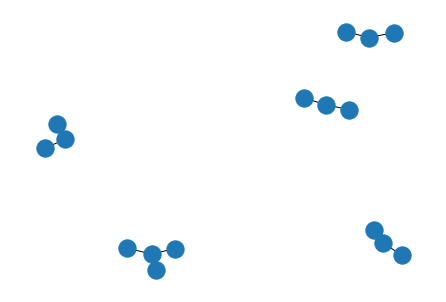

In [22]:
testererer = Eurovision_Decade_DataFrame("C:\\Users\\josia\\Documents\\GitHub\\modernDataAnalytics2022\\data\\Voting_totals.csv", 
                                         round_type = "all", vote_type = "J")

network_and_communities(cutoff_values(testererer, top = 15), show_plot = "Y")

[{'Albania', 'Greece', 'Cyprus'}, {'Moldova', 'Romania', 'Russia'}, {'Denmark', 'Sweden', 'Norway'}, {'United Kingdom', 'Ireland', 'Lithuania'}, {'Serbia', 'Macedonia'}, {'Georgia', 'Azerbaijan'}, {'Ukraine', 'Belarus'}]


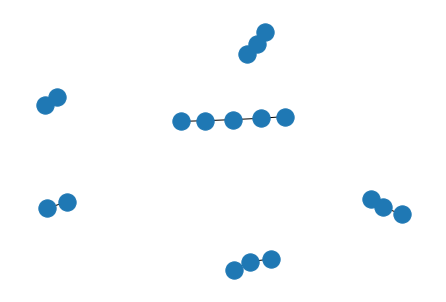

In [23]:
testererer = Eurovision_Decade_DataFrame("C:\\Users\\josia\\Documents\\GitHub\\modernDataAnalytics2022\\data\\Voting_totals.csv", 
                                         round_type = "all")

network_and_communities(cutoff_values(testererer, top = 15), show_plot = "Y")

In [24]:
 Eurovision_Decade_DataFrame("C:\\Users\\josia\\Documents\\GitHub\\modernDataAnalytics2022\\data\\Voting_totals.csv", 
                                         round_type = "all")["average_points"].mean()


0.744617970825877

In [25]:
# what about never voting for others??
# fucker_dislikes = fucker[fucker["average_points"] == 0]
# fucker_dislikes["Year"].unique()

In [26]:
# fucker_dislikes = fucker_dislikes[fucker_dislikes["Year"] >= 16000]
# fucker_dislikes["Year"] = round(fucker_dislikes["Year"]/2000, 2)

In [27]:
# fucker_dislikes["Year"].hist()

In [28]:

# dislikes = nx.from_pandas_edgelist(fucker_dislikes, "From country", "To country", ["Year"],
#                                    create_using=nx.DiGraph())

# weights = [round(dislikes[u][v]['Year'])/4 for u, v in dislikes.edges() if u != v]

# for n1,n2,attr in dislikes.edges(data=True):
#     print(n1,n2,attr)
# print(weights)
    
    
# fig = plt.figure(1, figsize=(17, 8), dpi=80)


# pos = nx.spring_layout(dislikes, k =.8)

# nx.draw_networkx_nodes(dislikes, pos, node_color='lightblue', node_size=200, label=True)
# nx.draw_networkx_edges(dislikes, pos, arrows=True, alpha = 0.5, width = weights)
# nx.draw_networkx_labels(dislikes, pos, font_color='r', font_size=10)


# # nx.draw_networkx(dislikes, with_labels = True, width = weights,pos = nx.spring_layout(, ), )

In [29]:
# from networkx.algorithms.community.label_propagation import label_propagation_communities
# undirected_dislikes = nx.from_pandas_edgelist(fucker_dislikes, "From country", "To country", ["Year"])
# # Didn't actually detect community because all are connected...
# communities = label_propagation_communities(undirected_dislikes)
# print([community for community in communities])

In [30]:
# # load geographic coordinate system for countries
import csv
country = [row[0].strip() for row in csv.reader(open(full_path("LonLat.csv")), delimiter=';')]    # clear spaces
# lat = [float(row[1]) for row in csv.reader(open(path + '\\LonLat.csv'), delimiter=';')]
# lon = [float(row[2]) for row in csv.reader(open(path + '\\LonLat.csv'), delimiter=';')]
# # define position in basemap
# position = {}
# for i in range(0, len(country)):
#     position[country[i]] = m(lon[i], lat[i])
country

['AFGHANISTAN',
 'ALBANIA',
 'ALGERIA',
 'AMERICAN SAMOA',
 'ANDORRA',
 'ANGOLA',
 'ANGUILLA',
 'ANTARCTICA',
 'ANTIGUA AND BARBUDA',
 'ARGENTINA',
 'ARMENIA',
 'ARUBA',
 'AUSTRALIA',
 'AUSTRIA',
 'AZERBAIJAN',
 'BAHAMAS',
 'BAHRAIN',
 'BANGLADESH',
 'BARBADOS',
 'BELARUS',
 'BELGIUM',
 'BELIZE',
 'BENIN',
 'BERMUDA',
 'BHUTAN',
 'BOLIVIA',
 'BOSNIA AND HERZEGOVINA',
 'BOTSWANA',
 'BOUVET ISLAND',
 'BRAZIL',
 'BRITISH INDIAN OCEAN TERRITORY',
 'BRUNEI',
 'BULGARIA',
 'BURKINA FASO',
 'BURUNDI',
 'CAMBODIA',
 'CAMEROON',
 'CANADA',
 'CAPE VERDE',
 'CAYMAN ISLANDS',
 'CENTRAL AFRICAN REPUBLIC',
 'CHAD',
 'CHILE',
 'CHINA',
 'CHRISTMAS ISLAND',
 'COCOS (KEELING) ISLANDS',
 'COLOMBIA',
 'COMOROS',
 'CONGO',
 'COOK ISLANDS',
 'COSTA RICA',
 'COTE IVOIRE',
 'CROATIA (HRVATSKA)',
 'CUBA',
 'CYPRUS',
 'CZECH REPUBLIC',
 'DENMARK',
 'DJIBOUTI',
 'DOMINICA',
 'DOMINICAN REPUBLIC',
 'ECUADOR',
 'EGYPT',
 'EL SALVADOR',
 'EQUATORIAL GUINEA',
 'ERITREA',
 'ESTONIA',
 'ETHIOPIA',
 'FALKLAND ISLANDS'

In [31]:
shitter_coords = pd.read_csv(full_path("LonLat.csv"), delimiter=";", 
                  names=["Country", "Lat", "Lon"])
shitter_coords

,Country,Lat,Lon
0,AFGHANISTAN,33.0000,65.0
1,ALBANIA,41.0000,20.0
2,ALGERIA,28.0000,3.0
3,AMERICAN SAMOA,-14.3333,-170.0
4,ANDORRA,42.5000,1.5
...,...,...,...
230,WESTERN SAHARA,24.5000,-13.0
231,YEMEN,15.0000,48.0
232,ZAIRE,-20.0000,30.0
233,ZAMBIA,-15.0000,30.0


In [38]:
# Finding distance between countries!
def proc_distance(dataframe):
    country = [row[0].strip() for row in csv.reader(open(full_path(dataframe)), delimiter=';')]
    pos = dict((land, similar(land.upper(), country)) for land in testererer["From country"].unique())
    take_2_2 = pd.DataFrame.from_dict(pos, orient='index')
    take_2_2.reset_index()
    take_2_2['Country'] = take_2_2.index
    fuzzy_merged = fuzzy_merge(shitter_coords, take_2_2, "Country", "Country", threshold=90, limit=1)
    fuzzy_merged['matches'].replace('', np.nan, inplace=True)
    fuzzy_merged.dropna(subset=['matches'], inplace=True)
    fuzzy_merged = fuzzy_merged.drop(['Country'], axis=1)
    print(len(fuzzy_merged["matches"]))
    dictionary_pos = fuzzy_merged.set_index('matches').T.to_dict('list')

    # for val in dictionary_pos:
    list_new = []
    for a, b in itertools.combinations(dictionary_pos, 2):
        list_new.append({"Country_A": a, "Country_B": b, "Distance": round(geopy.distance.geodesic(dictionary_pos[a], dictionary_pos[b]).km, 2)})

    distance_matrix = pd.DataFrame.from_dict(list_new)
    return distance_matrix



In [39]:

# TODO: FIND A WAY TO GET THE COMMON ENTRIES OF THESE DATAFRAMES SO A MATRIX CAN BE CONSTRUCTED..
gdp_data = proc_gdppc(dataframe = 'gdp-per-capita-worldbank.csv', year = 2000)
english = proc_english('EnglischLanguage.csv')

distance_data = proc_distance("LonLat.csv")





51


C:\Users\josia\Anaconda3\envs\test_python\lib\site-packages\ipykernel_launcher.py:13: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  del sys.path[0]


In [42]:
len(proc_english('EnglischLanguage.csv')["matches"].unique())
len(proc_gdppc(dataframe = 'gdp-per-capita-worldbank.csv', year = 2000)["matches"])
len(proc_distance("LonLat.csv")["Distance"])




51


C:\Users\josia\Anaconda3\envs\test_python\lib\site-packages\ipykernel_launcher.py:13: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  del sys.path[0]


1176

In [43]:
point_shares = testererer.groupby(["From country", "To country"]).sum()
point_shares = point_shares.reset_index()
point_shares = point_shares[(point_shares['From country'].isin(acceptable_countries)) & (point_shares['To country'].isin(acceptable_countries))]

point_shares = point_shares.drop(['Year', 'Points', 'sum_senders', 'sum_receivers', 'Contests_Shared'], axis=1)
point_shares = point_shares.drop(point_shares.columns[2], axis=1)
point_shares
point_shares.columns = [c.replace(' ', '_') for c in point_shares.columns]

df = pd.crosstab(point_shares.From_country, point_shares.To_country, point_shares.average_points, aggfunc=sum)
idx = df.columns.union(df.index)
df = df.reindex(index = idx, columns=idx, fill_value=0)
df_points = df.fillna(0)
# df_points = df_points + df_points.T - np.diag(np.diag(df_points))
df_points

,Australia,Austria,Belgium,Bulgaria,Croatia,Cyprus,Denmark,Estonia,Finland,France,...,Portugal,Romania,Russia,Slovenia,Spain,Sweden,Switzerland,The Netherlands,Turkey,Ukraine
Australia,0.000000,0.259136,2.550000,1.595238,0.047619,0.734219,1.646844,0.511047,0.521595,0.309524,...,1.095238,0.288095,0.869048,0.714286,0.329457,3.150498,0.047619,0.261905,0.000000,0.952381
Austria,0.657143,0.000000,3.181882,2.401440,3.760196,1.278284,4.679030,2.335090,1.869534,5.527508,...,1.360817,3.203408,3.937103,1.276882,3.180771,6.629516,5.832364,5.645043,2.323762,0.821595
Belgium,2.195238,5.236455,0.000000,1.588745,0.776945,3.542547,4.746763,1.323056,1.759166,5.428088,...,3.783547,2.524962,3.233480,0.706004,5.157726,7.640525,5.324166,8.465161,4.405260,2.153744
Bulgaria,1.214286,2.622571,2.103896,0.000000,1.464089,2.473817,1.146176,0.648243,0.478127,0.401993,...,0.493939,1.774338,1.630187,0.530303,0.217949,1.040053,0.460256,0.941558,3.321428,3.296826
Croatia,0.547619,1.799355,0.583266,1.908990,0.000000,3.571429,2.551548,1.142692,0.669173,1.376821,...,1.415805,0.963539,3.787619,4.475820,1.491405,1.420879,0.945967,1.980012,2.150721,2.596256
Cyprus,0.980952,2.613758,2.549485,3.768904,2.345022,0.000000,3.448596,1.559328,1.755092,3.597307,...,2.182778,2.973200,5.123143,0.811009,4.828843,5.929963,2.842893,1.629294,0.418803,3.636635
Denmark,3.098117,4.439364,4.758279,2.014598,0.241627,3.370132,0.000000,2.863314,2.076725,2.746714,...,1.068846,2.303855,3.005302,0.859760,1.634013,14.671541,4.483253,6.351594,2.932408,2.978539
Estonia,0.625000,3.319430,3.494451,2.004782,1.111371,2.698864,4.702369,0.000000,5.383317,1.718250,...,0.819767,1.291173,7.677474,0.651176,0.372750,6.846280,0.896770,4.161298,0.489084,3.690718
Finland,1.101190,3.989075,5.531667,1.258532,0.835812,4.405253,3.934777,6.380706,0.000000,5.054926,...,3.254853,1.212840,4.350504,0.644771,3.692011,9.399126,6.479288,3.964944,1.992559,1.102101
France,1.330177,3.871571,6.557824,2.302449,1.477162,2.035547,5.035355,3.003989,2.124743,0.000000,...,8.862345,3.421456,2.425869,1.206217,5.273698,6.153301,4.516620,6.370443,6.240123,0.907653


In [44]:
eng_gdp = list(set(distance_data["Country_A"]).intersection(gdp_data["matches"].unique()))
acceptable_countries = list(set(eng_gdp).intersection(english["matches"].unique()))
acceptable_countries = list(set(acceptable_countries).intersection(point_shares["From_country"].unique()))

acceptable_countries

['Denmark',
 'Sweden',
 'France',
 'Australia',
 'Poland',
 'Spain',
 'Belgium',
 'Norway',
 'Austria',
 'Germany',
 'Hungary',
 'Turkey',
 'Romania',
 'Italy',
 'Ukraine',
 'Switzerland',
 'Morocco',
 'Finland',
 'Luxembourg',
 'Slovenia',
 'Latvia',
 'Portugal',
 'Cyprus',
 'Lithuania',
 'Croatia',
 'Bulgaria',
 'Ireland',
 'Estonia',
 'The Netherlands',
 'Israel',
 'Malta',
 'Greece',
 'Russia']

[{'Denmark', 'Sweden', 'France', 'Iceland', 'Czech Republic', 'Azerbaijan', 'Poland', 'Spain', 'Australia', 'Serbia', 'San Marino', 'Belgium', 'Norway', 'Monaco', 'Armenia', 'Austria', 'Albania', 'The Netherands', 'Germany', 'Hungary', 'Turkey', 'Romania', 'Italy', 'Yugoslavia', 'Georgia', 'Switzerland', 'Ukraine', 'Morocco', 'Finland', 'Luxembourg', 'Slovenia', 'Latvia', 'Montenegro', 'Portugal', 'Cyprus', 'Croatia', 'Lithuania', 'Slovakia', 'Bulgaria', 'Andorra', 'United Kingdom', 'Serbia & Montenegro', 'Ireland', 'Estonia', 'Moldova', 'The Netherlands', 'Macedonia', 'Israel', 'Malta', 'Bosnia & Herzegovina', 'Greece', 'Belarus', 'Russia'}]


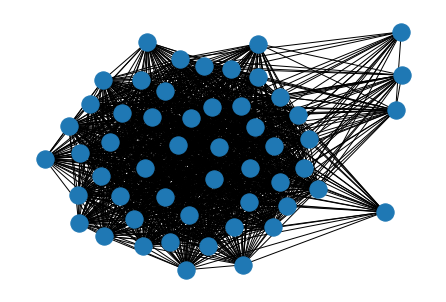

In [45]:



# cluster = pd.DataFrame.from_dict(communities)
# cluster['cluster'] = range(1, len(cluster) + 1)
# print(cluster.head(10))
# print(communities)

# I guess louvain probably works the best for getting these labels without struggle
from community import community_louvain
partition = community_louvain.best_partition(network_and_communities(testererer))
partition

count = 0
for com in set(partition.values()) :
    count = count + 1.
    list_nodes = [nodes for nodes in partition.keys()
                                if partition[nodes] == com]

In [46]:
clusters_df = pd.DataFrame.from_dict(partition, orient='index', columns=['cluster']).reset_index()
clusters_df.rename(columns={"index": "Country"}, errors="raise", inplace=True)
clusters_df
# partition


,Country,cluster
0,Austria,0
1,Belgium,0
2,Denmark,0
3,Finland,0
4,France,0
5,Germany,0
6,Greece,0
7,Ireland,0
8,Israel,1
9,Italy,1


In [47]:
# this was stolen from:
# https://github.com/DataMettle/eurovision/blob/master/Modelling%20Eurovision%20voting%20patterns.ipynb


# Download the file: Done!
# https://www.naturalearthdata.com/http//www.naturalearthdata.com/download/10m/cultural/ne_10m_admin_0_countries.zip
# and place the contents of the zip in the data folder.

country_codes = pd.read_csv(full_path('country_codes.csv'))

shapefile = full_path('ne_10m_admin_0_countries.shp')
shape = gpd.read_file(shapefile)
gdf = shape.to_crs("+init=epsg:3035")
gdf_australia = shape.to_crs("+init=epsg:3577")

# Each country needs to be outputted with a label..
# take this from our network outputs
# clusters_df = pd.DataFrame(
#     {
#         'Country': countries,
#         'cluster': clusters,
#     }
# )


def merge_with_map(map_df, country_codes):
    """Adds full country names to country codes. Also adjusts some country names."""
    return (
        pd.merge(map_df, country_codes)
        .replace({'Russian Federation': 'Russia',
                  'Netherlands': 'The Netherlands',
                  'Czechia': 'Czech Republic',
                  'Bosnia and Herzegovina': 'Bosnia & Herzegovina',
                  'Moldova, Republic of': 'Moldova',
                  'Macedonia, the former Yugoslav Republic of': 'F.Y.R. Macedonia'})
    )

eurovision_map = merge_with_map(gdf, country_codes)

eurovision_map_australia = merge_with_map(gdf_australia, country_codes)

C:\Users\josia\Anaconda3\envs\test_python\lib\site-packages\pyproj\crs\crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\josia\Anaconda3\envs\test_python\lib\site-packages\pyproj\crs\crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


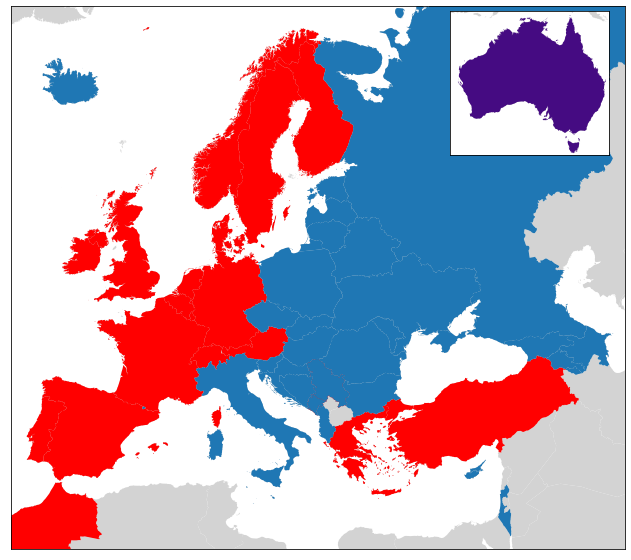

In [51]:
# This shit is straight up stolen from kaggle so probably change parts of it!

from mpl_toolkits.axes_grid1.inset_locator import inset_axes

f, ax = plt.subplots(1, figsize=(11, 10))
f.subplots_adjust(hspace=0.0, wspace=0.0)
gdf.plot(ax=ax, color='lightgrey')

eurovision_map_cluster = pd.merge(eurovision_map, clusters_df, left_on='Country name', right_on='Country')


# Gonna have to change the cmap s.t. any number of colors are taken.. maybe some viridis color pallete or something
eurovision_map_cluster[eurovision_map_cluster['cluster'] == 0].plot(ax=ax,
                                                                    color='r',
                                                                    vmin=-0.05)
eurovision_map_cluster[eurovision_map_cluster['cluster'] == 1].plot(ax=ax,
                                                                    vmin=-0.05)

eurovision_map_australia_cluster = pd.merge(eurovision_map_australia, clusters_df, left_on='Country name', right_on='Country')
inset_ax = inset_axes(ax, 
                      width=1.5*(2.5/1.5),
                      height=1.2*(2.5/1.5),
                      loc=1)
gdf_australia.plot(ax=inset_ax, color='lightgrey')
eurovision_map_australia_cluster.plot(ax=inset_ax,
                                      cmap='Purples',
                                      vmin=-0.05)
inset_ax.set_xlim(-0.21e7, 0.22e7)
inset_ax.set_ylim(-0.49e7, -0.1e7)
inset_ax.axes.get_xaxis().set_visible(False)
inset_ax.axes.get_yaxis().set_visible(False)

# eurovision_map_cluster[eurovision_map_cluster['cluster'] == 2].plot(ax=ax,
#                                                                     color='g',
#                                                                     vmin=-0.05)
# eurovision_map_cluster[eurovision_map_cluster['cluster'] == 3].plot(ax=ax,
#                                                                     color='y',
#                                                                     vmin=-0.05)
# eurovision_map_cluster[eurovision_map_cluster['cluster'] == 4].plot(ax=ax,
#                                                                     color='m',
#                                                                     vmin=-0.05)
# eurovision_map_cluster[eurovision_map_cluster['cluster'] == 5].plot(ax=ax,
#                                                                     color='purple',
#                                                                     vmin=-0.05)

ax.set_xlim(0.25e7, 0.77e7)
ax.set_ylim(0.10e7, 0.56e7)
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
# plt.savefig('images/clusters_map.png', bbox_inches='tight', dpi=150)

In [52]:
distance_data = distance_data[(distance_data['Country_A'].isin(acceptable_countries)) & (distance_data['Country_B'].isin(acceptable_countries))]
distance_data


gdp_data = gdp_data[(gdp_data['matches'].isin(acceptable_countries))]
english = english[(english['matches'].isin(acceptable_countries))]

gdp_data.head()

,Year,GDP_PPP_2017_dol,matches
336,2000,38343.00,Australia
367,2000,46403.28,Austria
584,2000,43023.31,Belgium
889,2000,10201.28,Bulgaria
1446,2000,18183.59,Croatia


In [53]:
# How to get adjacency matrix...
df = pd.crosstab(gdp_data.matches, gdp_data.matches, gdp_data.GDP_PPP_2017_dol, aggfunc=sum)
idx = df.columns.union(df.index)
df = df.reindex(index = idx, columns=idx, fill_value=0)
df_gdp = df.fillna(0)
# df_gdp = df_gdp + df_gdp.T - np.diag(np.diag(df_gdp))
df_gdp

matches,Australia,Austria,Belgium,Bulgaria,Croatia,Cyprus,Denmark,Estonia,Finland,France,...,Portugal,Romania,Russia,Slovenia,Spain,Sweden,Switzerland,The Netherlands,Turkey,Ukraine
matches,,,,,,,,,,,,,,,,,,,,,
Australia,38343.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00
Austria,0.0,46403.28,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00
Belgium,0.0,0.00,43023.31,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00
Bulgaria,0.0,0.00,0.00,10201.28,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00
Croatia,0.0,0.00,0.00,0.00,18183.59,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00
Cyprus,0.0,0.00,0.00,0.00,0.00,33013.98,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00
Denmark,0.0,0.00,0.00,0.00,0.00,0.00,48907.01,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00
Estonia,0.0,0.00,0.00,0.00,0.00,0.00,0.00,17778.97,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00
Finland,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,39894.19,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00


In [54]:
# How to get adjacency matrix...
df = pd.crosstab(english.matches, english.matches, english.percent_english, aggfunc=sum)
idx = df.columns.union(df.index)
df = df.reindex(index = idx, columns=idx, fill_value=0)
df_eng = df.fillna(0)
# df_eng = df_eng + df_eng.T - np.diag(np.diag(df_eng))
df_eng

matches,Australia,Austria,Belgium,Bulgaria,Croatia,Cyprus,Denmark,Estonia,Finland,France,...,Portugal,Romania,Russia,Slovenia,Spain,Sweden,Switzerland,The Netherlands,Turkey,Ukraine
matches,,,,,,,,,,,,,,,,,,,,,
Australia,92.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0
Austria,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0
Belgium,0.0,0.0,60.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0
Bulgaria,0.0,0.0,0.0,25.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0
Croatia,0.0,0.0,0.0,0.0,60.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0
Cyprus,0.0,0.0,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0
Denmark,0.0,0.0,0.0,0.0,0.0,0.0,86.0,0.0,0.0,0.0,...,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0
Estonia,0.0,0.0,0.0,0.0,0.0,0.0,0.0,50.0,0.0,0.0,...,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0
Finland,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,70.0,0.0,...,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0


In [55]:
#######################################################################
# Constants
#######################################################################
NCOUNTRIES = 30
DIRECTED = True
NPERMUTATIONS = 2000

In [56]:
def getMatrix(path, directed=False, log1p=False):
    matrix = np.zeros(shape=(NCOUNTRIES,NCOUNTRIES))
    with open(path, 'r') as f:
        for line in f:
            data = line.replace('\n','').split(' ')
            c1 = int(data[0])-1
            c2 = int(data[1])-1
            v = np.log1p(float(data[2])) if log1p else float(data[2])
            matrix[c1][c2] = v # real data from file
            if not DIRECTED:
                matrix[c2][c1] = v # symmetry
    print('{} loaded as a matrix!'.format(path))
    return matrix

In [57]:
# How to get adjacency matrix...
df = pd.crosstab(distance_data.Country_A, distance_data.Country_B, distance_data.Distance, aggfunc=sum)
idx = df.columns.union(df.index)
df = df.reindex(index = idx, columns=idx, fill_value=0)
df_dist = df.fillna(0)
# df_dist = df_dist + df_dist.T - np.diag(np.diag(df_dist))
df_dist

,Australia,Austria,Belgium,Bulgaria,Croatia,Cyprus,Denmark,Estonia,Finland,France,...,Portugal,Romania,Russia,Slovenia,Spain,Sweden,Switzerland,The Netherlands,Turkey,Ukraine
Australia,0.0,14366.99,14997.72,13418.51,14199.04,12535.13,14488.58,13504.05,13494.34,15243.51,...,16169.64,13468.23,10102.76,14240.22,15822.44,14073.95,14772.75,14839.91,12498.03,13000.95
Austria,0.0,0.00,784.25,1034.46,293.09,2133.96,991.15,1544.58,2010.77,879.06,...,1925.86,904.15,5461.78,195.53,1612.81,1636.03,405.98,790.93,1980.95,1397.21
Belgium,0.0,0.00,0.00,1812.24,1062.68,2918.19,699.29,1666.32,1954.06,557.41,...,1569.41,1638.04,5614.37,974.07,1355.23,1412.28,517.20,221.45,2749.99,2009.06
Bulgaria,0.0,0.00,0.00,0.00,797.50,1125.35,1800.32,1781.28,2338.01,1852.53,...,2774.96,333.37,5212.10,861.55,2431.89,2214.58,1408.81,1779.42,950.52,858.76
Croatia,0.0,0.00,0.00,0.00,0.00,1864.56,1265.48,1694.48,2196.78,1056.36,...,2027.98,746.71,5533.22,100.50,1695.37,1873.74,614.55,1083.18,1747.13,1320.26
Cyprus,0.0,0.00,0.00,0.00,0.00,0.00,2916.65,2717.20,3260.46,2873.59,...,3640.02,1395.38,5453.94,1946.58,3294.32,3258.01,2473.19,2900.45,478.24,1557.20
Denmark,0.0,0.00,0.00,0.00,0.00,0.00,0.00,1012.83,1254.86,1244.26,...,2262.83,1525.38,4922.38,1165.76,2054.25,727.02,1010.79,477.84,2640.05,1674.71
Estonia,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,557.19,2157.54,...,3229.17,1448.13,3970.53,1623.24,2983.76,689.53,1789.54,1454.73,2314.73,1179.38
Finland,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2492.44,...,3514.39,2004.73,3681.61,2116.69,3308.40,599.36,2190.57,1732.63,2844.27,1708.79
France,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,1090.10,1775.42,6126.25,1005.90,826.30,1965.80,473.67,772.46,2799.35,2269.58


In [58]:
# some crosstab matrix of values s.t. country average votes are in...


In [59]:
sim = pd.read_csv(full_path('sim_index.csv'),  header=0, skiprows=1, delimiter = " ")
sim

,Country,1\tCountry,2\tIndex
0,value\tRound,of,ESS
1,used,NaN,NaN
2,"UK\tIreland\t0,914\t2.",NaN,NaN
3,"Luxembourg\tSpain\t0,906\t2.",NaN,NaN
4,"Germany\tLuxembourg\t0,882\t2.",NaN,NaN
...,...,...,...
500,"Bulgaria\tSwitzerland\t0,392\t3.",NaN,NaN
501,"France\tRomania\t0,389\t4.",NaN,NaN
502,"Bulgaria\tTurkey\t0,387\t4.",NaN,NaN
503,"Iceland\tSlovakia\t0,381\t2.",NaN,NaN


In [60]:
# X1 = getMatrix(full_path('country_trade_index.txt'),DIRECTED,True)
# X2 = getMatrix('data/country_distance_index.txt',DIRECTED,True)
# X3 = getMatrix('data/country_colonial_index.txt',DIRECTED)
# Y  = getMatrix('data/country_lang_index.txt',DIRECTED)
# X = {'GDP':df_gdp, 'DISTANCE':df_dist, 'English':df_eng}
X = {'DISTANCE':df_dist.to_numpy(), 'English':df_eng.to_numpy(), 'GDP':df_gdp.to_numpy()}
# X = {'DISTANCE':df_dist.to_numpy()}
Y = {'Points':df_points.to_numpy()}
# np.random.seed(1)
# X1
# pd.DataFrame(X1)[231][111]

In [61]:
df_eng.head()

matches,Australia,Austria,Belgium,Bulgaria,Croatia,Cyprus,Denmark,Estonia,Finland,France,...,Portugal,Romania,Russia,Slovenia,Spain,Sweden,Switzerland,The Netherlands,Turkey,Ukraine
matches,,,,,,,,,,,,,,,,,,,,,
Australia,92.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Austria,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Belgium,0.0,0.0,60.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Bulgaria,0.0,0.0,0.0,25.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Croatia,0.0,0.0,0.0,0.0,60.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [62]:
len(df_gdp.to_numpy())

33

In [63]:
print(len(df_dist.to_numpy()))

print(len(df_eng.to_numpy()))


33
33


In [64]:
# Issue: english and GDP are not shared values... maybe it is best to create some comparison df

mrqap = MRQAP(Y=Y, X=X, npermutations=NPERMUTATIONS, diagonal=False, directed=True)

mrqap.mrqap()

In [65]:
mrqap.summary()



=== Summary OLS (original) ===
                            OLS Regression Results                            
Dep. Variable:                 Points   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     21.12
Date:                Thu, 02 Jun 2022   Prob (F-statistic):           4.85e-06
Time:                        14:46:00   Log-Likelihood:                -2298.8
No. Observations:                1056   AIC:                             4602.
Df Residuals:                    1054   BIC:                             4612.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.737

C:\Users\josia\Anaconda3\envs\test_python\lib\site-packages\statsmodels\regression\linear_model.py:1918: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])


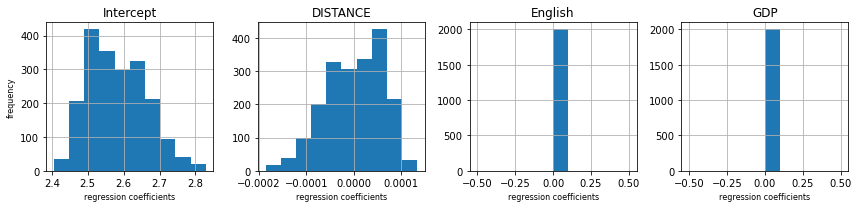

In [66]:
%matplotlib inline  
mrqap.plot('betas', fn=None)

In [67]:
# something about the bias of our guys

testererer["avg_points_new"] = round(testererer["Points"]/testererer["Contests_Shared"], 2)
testererer.tail()



,Decade,From country,To country,Year,Points,Duplicate,sum_senders,sum_receivers,average_points,Contests_Shared,avg_points_new
6142,2010s,United Kingdom,Sweden,32238,70,0.0,558.0,374.0,2.215744,16,4.38
6143,2010s,United Kingdom,Switzerland,20143,20,0.0,245.0,193.0,0.703308,10,2.00
6144,2010s,United Kingdom,The Netherlands,22164,30,0.0,389.0,259.0,1.076829,11,2.73
6145,2010s,United Kingdom,Turkey,10055,26,0.0,142.0,105.0,1.034606,5,5.20
6146,2010s,United Kingdom,Ukraine,32229,40,0.0,555.0,371.0,1.347889,16,2.50


In [68]:
testererer[testererer["From country"] == "Albania"].sort_values(by=['avg_points_new'],  ascending=False)

,Decade,From country,To country,Year,Points,Duplicate,sum_senders,sum_receivers,average_points,Contests_Shared,avg_points_new
2029,2000s,Albania,Greece,16052,87,0.0,298.0,187.0,2.461791,8,10.88
4093,2010s,Albania,Italy,22167,119,0.0,455.0,286.0,2.881839,11,10.82
4113,2010s,Albania,Turkey,6033,30,0.0,102.0,70.0,1.014652,3,10.00
4096,2010s,Albania,Macedonia,16118,74,0.0,188.0,150.0,3.396970,8,9.25
2054,2000s,Albania,Turkey,18060,83,0.0,342.0,216.0,2.309373,9,9.22
...,...,...,...,...,...,...,...,...,...,...,...
2034,2000s,Albania,Latvia,18059,0,0.0,323.0,210.0,0.000000,9,0.00
4107,2010s,Albania,Slovakia,2010,0,0.0,20.0,17.0,0.000000,1,0.00
2035,2000s,Albania,Lithuania,16054,0,0.0,279.0,181.0,0.000000,8,0.00
2027,2000s,Albania,Georgia,8030,0,0.0,149.0,96.0,0.000000,4,0.00


In [69]:
# FYR Macedonia and Macedonia need to be revised

# something to deal with random countries in the contest?
simple_pred = testererer.groupby(["From country","To country",'avg_points_new']).sum()
simple_pred.sort_values(by=['avg_points_new'],  ascending=False)
simple_pred = simple_pred.reset_index()
simple_pred = simple_pred.groupby(["To country"]).sum()
simple_pred.sort_values(by=['avg_points_new'],  ascending=False)

,avg_points_new,Year,Points,Duplicate,sum_senders,sum_receivers,average_points,Contests_Shared
To country,,,,,,,,
Sweden,596.17,3031824,6253,0.0,46508.0,34759.0,231.387892,1513
Israel,574.61,2735665,4330,0.0,40866.0,30847.0,173.127906,1365
Ireland,542.52,2530479,3947,0.0,35326.0,27884.0,171.919254,1264
Greece,514.64,2691125,4212,0.0,39930.0,30278.0,157.055301,1343
United Kingdom,501.22,2630632,3442,0.0,42382.0,31290.0,146.209008,1314
Russia,474.99,1936753,4406,0.0,31982.0,22454.0,147.324860,964
Norway,452.70,2928636,4270,0.0,43410.0,33267.0,162.075754,1462
France,442.20,2596938,3162,0.0,42076.0,30984.0,126.493660,1297
Denmark,435.19,2689946,3928,0.0,40940.0,30454.0,150.901857,1342


In [153]:
# Given x countries are in a contest, who among them will win?





















duplicate_lang_countries




['Germany', 'Italy', 'The Netherlands', 'Austria', 'Greece', 'Switzerland']

In [273]:
# language similarity dataframe!

langSim = pd.read_html('https://www.ezglot.com/language-similarity-matrix.html')[0]

langConv = dict({'Bosnian': 'Bosnia & Herzegovina', 'Serbian': 'Serbia', 'Croatian': 'Croatia',
                'Slovenian': 'Slovenia', 'Polish': 'Poland', 'Slovak': 'Slovakia', 'Czech': 'CzechRepublic',
                'Ukrainian': 'Ukraine', 'Russian': 'Russia', 'Macedonian': 'Macedonia', 'Bulgarian': 'Bulgaria',
                'Belarusian': 'Belarus', 'Spanish': 'Spain', 'English': 'United Kingdom', 'English': 'Australia',
                'Italian': 'Italy', 'Portuguese': 'Portugal', 'Romanian': 'Romania', 'Estonian': 'Estonia',
                'Armenian': 'Armenia', 'Latvian': 'Latvia', 'German': 'Germany', 'Turkish': 'Turkey',
                'Dutch': 'Netherlands', 'Dutch': 'Belgium', 'Azerbaijani': 'Azerbaijan', 'Lithuanian': 'Lithuania',
                'Maltese': 'Malta', 'Hungarian': 'Hungary', 'Luxembourgish': 'Luxembourg', 'Finnish': 'Finland',
                'Georgian': 'Georgia', 'Greek': 'Greece', 'Irish': 'Ireland', 'Danish': 'Denmark', 'Swedish': 'Sweden',
                'Icelandic': 'Iceland', 'Hebrew': 'Israel', 'Serbian': 'Serbia', 'French': 'France', 'German': 'Austria',
                'Albanian': 'Albania', 'Greek': 'Cyprus', 'German': 'Switzerland', 'Arabic':'Morocco',
                'Norwegian Bokmål': 'Norway'})


langConv_rev = {'Bosnia Herzegovina': 'Bosnian',
 'Serbia': 'Serbian',
 'Croatia': 'Croatian',
 'Slovenia': 'Slovenian',
 'Poland': 'Polish',
 'Slovakia': 'Slovak',
 'CzechRepublic': 'Czech',
 'Ukraine': 'Ukrainian',
 'Russia': 'Russian',
 'Macedonia': 'Macedonian',
 'Bulgaria': 'Bulgarian',
 'Belarus': 'Belarusian',
 'Spain': 'Spanish',
 'Australia': 'English',
 'Portugal': 'Portuguese',
 'Romania': 'Romanian',
 'Estonia': 'Estonian',
 'Armenia': 'Armenian',
 'Latvia': 'Latvian',
 'Turkey': 'Turkish',
 'Belgium': 'Dutch',
 'Azerbaijan': 'Azerbaijani',
 'Lithuania': 'Lithuanian',
 'Malta': 'Maltese',
 'Hungary': 'Hungarian',
 'Luxembourg': 'Luxembourgish',
 'Finland': 'Finnish',
 'Georgia': 'Georgian',
 'Cyprus': 'Greek',
 'Ireland': 'Irish',
 'Denmark': 'Danish',
 'Sweden': 'Swedish',
 'Iceland': 'Icelandic',
 'Israel': 'Hebrew',
 'France': 'French',
 'Albania': 'Albanian',
 'Morocco': 'Arabic',
 'Norway': 'Norwegian Bokmål',
 'The Netherlands': 'Dutch',
 'Germany': 'German',
 'Italy': 'Italian',
 'Austria': 'German',
 'Greece': 'Greek',
 'Switzerland': 'German'}



# res = dict((v,k) for k,v in langConv.items())

# it is because Greek goes to both cyprus AND greece, same with German!
# gotta fix this...

# ['Germany', 'Italy', 'The Netherlands', 'Austria', 'Greece', 'Switzerland']
langConv
# res

{'Bosnian': 'Bosnia & Herzegovina',
 'Serbian': 'Serbia',
 'Croatian': 'Croatia',
 'Slovenian': 'Slovenia',
 'Polish': 'Poland',
 'Slovak': 'Slovakia',
 'Czech': 'CzechRepublic',
 'Ukrainian': 'Ukraine',
 'Russian': 'Russia',
 'Macedonian': 'Macedonia',
 'Bulgarian': 'Bulgaria',
 'Belarusian': 'Belarus',
 'Spanish': 'Spain',
 'English': 'Australia',
 'Italian': 'Italy',
 'Portuguese': 'Portugal',
 'Romanian': 'Romania',
 'Estonian': 'Estonia',
 'Armenian': 'Armenia',
 'Latvian': 'Latvia',
 'German': 'Switzerland',
 'Turkish': 'Turkey',
 'Dutch': 'Belgium',
 'Azerbaijani': 'Azerbaijan',
 'Lithuanian': 'Lithuania',
 'Maltese': 'Malta',
 'Hungarian': 'Hungary',
 'Luxembourgish': 'Luxembourg',
 'Finnish': 'Finland',
 'Georgian': 'Georgia',
 'Greek': 'Cyprus',
 'Irish': 'Ireland',
 'Danish': 'Denmark',
 'Swedish': 'Sweden',
 'Icelandic': 'Iceland',
 'Hebrew': 'Israel',
 'French': 'France',
 'Albanian': 'Albania',
 'Arabic': 'Morocco',
 'Norwegian Bokmål': 'Norway'}

In [126]:
def get_key(val, dictionary):
    for key, value in dictionary.items():
         if val == value:
             return key



In [215]:
langConv_rev

{'Bosnia Herzegovina': 'Bosnian',
 'Serbia': 'Serbian',
 'Croatia': 'Croatian',
 'Slovenia': 'Slovenian',
 'Poland': 'Polish',
 'Slovakia': 'Slovak',
 'CzechRepublic': 'Czech',
 'Ukraine': 'Ukrainian',
 'Russia': 'Russian',
 'Macedonia': 'Macedonian',
 'Bulgaria': 'Bulgarian',
 'Belarus': 'Belarusian',
 'Spain': 'Spanish',
 'Australia': 'English',
 'San Marino': 'Italian',
 'Portugal': 'Portuguese',
 'Romania': 'Romanian',
 'Estonia': 'Estonian',
 'Armenia': 'Armenian',
 'Latvia': 'Latvian',
 'Turkey': 'Turkish',
 'Belgium': 'Dutch',
 'Azerbaijan': 'Azerbaijani',
 'Lithuania': 'Lithuanian',
 'Malta': 'Maltese',
 'Hungary': 'Hungarian',
 'Luxembourg': 'Luxembourgish',
 'Finland': 'Finnish',
 'Georgia': 'Georgian',
 'Cyprus': 'Greek',
 'Ireland': 'Irish',
 'Denmark': 'Danish',
 'Sweden': 'Swedish',
 'Iceland': 'Icelandic',
 'Israel': 'Hebrew',
 'France': 'French',
 'Albania': 'Albanian',
 'Morocco': 'Arabic',
 'Norway': 'Norwegian Bokmål',
 'The Netherlands': 'Dutch',
 'Germany': 'German

In [175]:
get_key("German", langConv)
# langConv['Germany']
english["matches"].unique()

array(['Germany', 'France', 'Australia', 'Italy', 'The Netherlands',
       'Poland', 'Turkey', 'Spain', 'Sweden', 'Russia', 'Belgium',
       'Israel', 'Austria', 'Romania', 'Greece', 'Denmark', 'Switzerland',
       'Morocco', 'Norway', 'Ukraine', 'Ireland', 'Finland', 'Portugal',
       'Croatia', 'Hungary', 'Bulgaria', 'Slovenia', 'Lithuania',
       'Latvia', 'Estonia', 'Cyprus', 'Malta', 'Luxembourg'], dtype=object)

In [307]:
# df_test_2.columns[-6:]
# ['Germany', 'Italy', 'The Netherlands', 'Austria', 'Greece', 'Switzerland']
# len(df_test_2.columns.intersection(english["matches"]))
langs =  [x for x in df_test_2.index if x not in df_dist.columns]
langs
len(df_dist.columns)
len(df_test_2.index)


64

In [304]:
[print(x) for x in df_dist.columns]

Australia
Austria
Belgium
Bulgaria
Croatia
Cyprus
Denmark
Estonia
Finland
France
Germany
Greece
Hungary
Ireland
Israel
Italy
Latvia
Lithuania
Luxembourg
Malta
Morocco
Norway
Poland
Portugal
Romania
Russia
Slovenia
Spain
Sweden
Switzerland
The Netherlands
Turkey
Ukraine


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [301]:
english["matches"].unique()

array(['Germany', 'France', 'Australia', 'Italy', 'The Netherlands',
       'Poland', 'Turkey', 'Spain', 'Sweden', 'Russia', 'Belgium',
       'Israel', 'Austria', 'Romania', 'Greece', 'Denmark', 'Switzerland',
       'Morocco', 'Norway', 'Ukraine', 'Ireland', 'Finland', 'Portugal',
       'Croatia', 'Hungary', 'Bulgaria', 'Slovenia', 'Lithuania',
       'Latvia', 'Estonia', 'Cyprus', 'Malta', 'Luxembourg'], dtype=object)

In [272]:

for x in duplicate_lang_countries:
    df_test_2.iloc[df_test_2.index ==x, :] =  df_test_2[x].T

np.fill_diagonal(df_test_2.values, 100)   
df_test_2

,Croatia,Slovenia,Poland,Ukraine,Russia,Bulgaria,Spain,Portugal,Australia,Belgium,...,Sweden,Morocco,Israel,Norway,Germany,Italy,The Netherlands,Austria,Greece,Switzerland
Croatia,100.0,11.0,14.0,12.0,9.0,9.0,-1.0,-1.0,4.0,-1.0,...,4.0,-1.0,-1.0,-1.0,5.0,-1.0,-1.0,5.0,5.0,5.0
Slovenia,17.0,100.0,12.0,11.0,7.0,8.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
Poland,14.0,8.0,100.0,9.0,15.0,9.0,9.0,6.0,12.0,6.0,...,7.0,-1.0,-1.0,-1.0,9.0,7.0,6.0,9.0,5.0,9.0
Ukraine,19.0,11.0,14.0,100.0,55.0,25.0,8.0,6.0,12.0,-1.0,...,7.0,-1.0,-1.0,-1.0,8.0,6.0,-1.0,8.0,-1.0,8.0
Russia,11.0,5.0,19.0,43.0,100.0,17.0,7.0,4.0,11.0,4.0,...,5.0,-1.0,-1.0,-1.0,7.0,5.0,4.0,7.0,9.0,7.0
Bulgaria,14.0,8.0,14.0,25.0,21.0,100.0,-1.0,-1.0,7.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,8.0,-1.0
Spain,-1.0,-1.0,14.0,9.0,9.0,-1.0,100.0,50.0,17.0,10.0,...,9.0,-1.0,-1.0,-1.0,12.0,35.0,10.0,12.0,16.0,12.0
Portugal,-1.0,-1.0,9.0,5.0,5.0,-1.0,42.0,100.0,14.0,6.0,...,5.0,-1.0,-1.0,-1.0,7.0,18.0,6.0,7.0,10.0,7.0
Australia,6.0,-1.0,19.0,12.0,14.0,7.0,16.0,15.0,100.0,23.0,...,19.0,-1.0,-1.0,-1.0,28.0,20.0,23.0,28.0,18.0,28.0
Belgium,-1.0,-1.0,6.0,-1.0,3.0,-1.0,6.0,4.0,13.0,100.0,...,6.0,-1.0,-1.0,-1.0,12.0,4.0,100.0,12.0,4.0,12.0


In [310]:
# Trying to get a bigger dataframe, failing :(


# need to drop italy and switzerland!!!!!!! 

# something is fucked up here!
dfTest = langSim

dfTest = dfTest.replace(langConv)

df_test_2 = dfTest

# duplicate_lang_countries = [x for x in english["matches"].unique() if x not in df1.columns]
# need to duplicate the duplicated languages somehow...
for x in duplicate_lang_countries:
    df_test_2[[x]] = dfTest[[langConv_rev[x]]]


# make the assumption of symmetry???
df_test_2.index = df_test_2.iloc[:,0]
df_test_2 = df_test_2.drop(['Unnamed: 0'], axis = 1)


zero_pad = pd.DataFrame(np.zeros((6, 99)))

zero_pad.columns = df_test_2.columns
zero_pad.index = df_test_2.columns[-6:]
df_test_2 = df_test_2.append(zero_pad)


df_test_2 = df_test_2.replace(langConv)
df_test_2.columns = df_test_2.index


df_test_2 = df_test_2[df_test_2.columns.intersection(english["matches"])]
df_test_2 = df_test_2.drop(langs, axis=0)


# countries_columns = df_test_2.columns
# # print(np.triu(df_test_2) - np.tril(df_test_2).T)

# df_test_2 = np.triu(df_test_2)

# df_test_2 = pd.DataFrame(df_test_2)
# # print(df_test_2)
# zero_pad = pd.DataFrame(np.zeros((6, 99)))

# df_test_2 = df_test_2.append(zero_pad)



# df_test_2 = df_test_2.to_numpy() + df_test_2.T.to_numpy() - np.diag(np.diag(df_test_2))
# print(len(np.diag(np.diag(df_test_2))))
# df_test_2 = pd.DataFrame(df_test_2)

# df_test_2.index = countries_columns
# df_test_2.columns = df_test_2.index

# # df1 = df_test_2



langs =  [x for x in df_test_2.index if x not in df_dist.columns]
langs
df_test_2 = df_test_2.drop(langs, axis=0)

langs =  [x for x in df_test_2.index if x not in english["matches"].unique()]
print(langs)


for x in duplicate_lang_countries:
    df_test_2.iloc[df_test_2.index ==x, :] =  df_test_2[x].T

np.fill_diagonal(df_test_2.values, 100)   

# Norway	Germany	The Netherlands	Austria	Greece

# GE BE = 12.0
# GER GRE = 3


# df_test_2 = df_test_2[df_test_2.columns.intersection(english["matches"])]
df_test_2
# # df1 = df1.drop(langs, axis=0)
# df1
# holder

[]


,Croatia,Slovenia,Poland,Ukraine,Russia,Bulgaria,Spain,Portugal,Italy,Italy,...,Ireland,Denmark,Sweden,Morocco,Israel,Norway,Germany,The Netherlands,Austria,Greece
Croatia,100.0,11.0,14.0,12.0,9.0,9.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,4.0,-1.0,-1.0,-1.0,5.0,-1.0,5.0,5.0
Slovenia,17.0,100.0,12.0,11.0,7.0,8.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
Poland,14.0,8.0,100.0,9.0,15.0,9.0,9.0,6.0,7.0,7.0,...,-1.0,6.0,7.0,-1.0,-1.0,-1.0,9.0,6.0,9.0,5.0
Ukraine,19.0,11.0,14.0,100.0,55.0,25.0,8.0,6.0,6.0,6.0,...,-1.0,6.0,7.0,-1.0,-1.0,-1.0,8.0,-1.0,8.0,-1.0
Russia,11.0,5.0,19.0,43.0,100.0,17.0,7.0,4.0,5.0,5.0,...,-1.0,-1.0,5.0,-1.0,-1.0,-1.0,7.0,4.0,7.0,9.0
Bulgaria,14.0,8.0,14.0,25.0,21.0,100.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,8.0
Spain,-1.0,-1.0,14.0,9.0,9.0,-1.0,100.0,50.0,35.0,35.0,...,7.0,-1.0,9.0,-1.0,-1.0,-1.0,12.0,10.0,12.0,16.0
Portugal,-1.0,-1.0,9.0,5.0,5.0,-1.0,42.0,100.0,18.0,18.0,...,-1.0,-1.0,5.0,-1.0,-1.0,-1.0,7.0,6.0,7.0,10.0
Italy,-1.0,-1.0,7.0,6.0,5.0,-1.0,35.0,18.0,100.0,20.0,...,5.0,-1.0,-1.0,-1.0,3.0,0.0,0.0,0.0,0.0,0.0
Australia,6.0,-1.0,19.0,12.0,14.0,7.0,16.0,15.0,20.0,100.0,...,12.0,6.0,19.0,-1.0,-1.0,-1.0,28.0,23.0,28.0,18.0


In [314]:
shit = list(df_test_2.index)
set([x for x in shit if shit.count(x) > 1])


{'Italy', 'Switzerland'}

In [152]:
[x for x in english["matches"].unique() if x not in df1.columns]

['Germany',
 'France',
 'Australia',
 'Italy',
 'The Netherlands',
 'Poland',
 'Turkey',
 'Spain',
 'Sweden',
 'Russia',
 'Belgium',
 'Israel',
 'Austria',
 'Romania',
 'Greece',
 'Denmark',
 'Switzerland',
 'Morocco',
 'Norway',
 'Ukraine',
 'Ireland',
 'Finland',
 'Portugal',
 'Croatia',
 'Hungary',
 'Bulgaria',
 'Slovenia',
 'Lithuania',
 'Latvia',
 'Estonia',
 'Cyprus',
 'Malta',
 'Luxembourg']

In [103]:
methest = pd.read_html('https://www.ezglot.com/language-similarity-matrix.html')[0]

In [106]:
methest[methest["Unnamed: 0"] == "Greek"]
# methest.head()

,Unnamed: 0,Bosnian,Serbian,Croatian,Slovenian,Polish,Slovak,Czech,Ukrainian,Russian,...,Arabic,Hebrew,Norwegian Bokmål,Northern Sami,Tatar,Kazakh,Mandarin Chinese,Japanese,Thai,Lao
49,Greek,-1,4,2,-1,2,-1,2,-1,3,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1


In [105]:
langSim[langSim["Unnamed: 0"] == "Greek"]



,Unnamed: 0,Bosnian,Serbian,Croatian,Slovenian,Polish,Slovak,Czech,Ukrainian,Russian,...,Arabic,Hebrew,Norwegian Bokmål,Northern Sami,Tatar,Kazakh,Mandarin Chinese,Japanese,Thai,Lao
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
